In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
#dados das eleições de 2006 e 2010
train = pd.read_csv("../data/train.csv")
#dados das eleições de 2014
test = pd.read_csv("../data/test.csv")

# dumy da variável alvo, eleito = 1 e nao_eleito = 0
y = train["situacao"]
y = y.replace(['nao_eleito', 'eleito'], [0, 1])

#removendo variável alvo dos dados de treino
train = train.drop(columns=['situacao'])
#merge treino e teste
data = pd.concat((train, test))
#removendo variáveis irrelevantes
data = data.drop(columns=['sequencial_candidato', 'nome', 'cargo',
                            'quantidade_doacoes', 'total_receita',
                            'quantidade_despesas', 'total_despesa'])

#selecionando atributos numéricos
attr_num = data.dtypes[data.dtypes != "object"].index
#normalizando variáveis numéricas exceto ano
data[attr_num[1:]] = np.log1p(data[attr_num[1:]])

#dummy das variáveis categoricas
data = pd.get_dummies(data)

x = data.loc[data['ano'] != 2014]
test = data.loc[data['ano'] == 2014]

### 1- Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso?

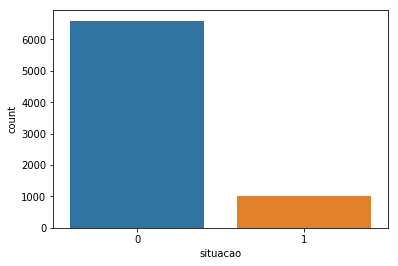

In [3]:
#plotando distribuição da variável alvo
sns.countplot(y)            

As classes estão claramente desbalanceadas, essa diferença pode enviesar a aprendizagem dos modelos. Isso pode ser tratrado por meio de técnicas de `Under-sampling`, neste caso vou utilizar a técnica NearMiss versão 2, que seleciona as amostras da classe majoritária para as quais a distância média até as N-amostras mais distantes da classe minoritária é a menor.

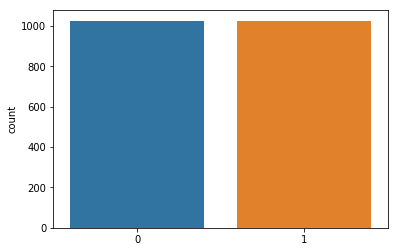

In [4]:
#balanceando as classes
from imblearn.under_sampling import NearMiss
nm = NearMiss(version=2)
x_balanced, y_balanced = nm.fit_resample(x, y)
#plotando distribuição da variável alvo
sns.countplot(y_balanced)

### 2) Treine: um modelo de regressão logística, KNN, uma árvore de decisão e um modelo de adaboost. Tune esses modelos usando validação cruzada e controle overfitting se necessário, considerando as particularidades de cada modelo.
A função NearMiss agrupa os dados em suas respectivas classes assim é preciso realizar um shuffle ao selecionar os folds 

In [5]:
#Função para calcular o f1 na validação cruzada
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
def report_cv(model, x, y):
    f1 = cross_val_score(model, x, y, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=3058))
    return(f1)

#### Regressão Logistíca

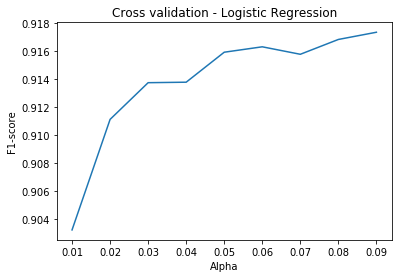

O melhor alpha é 0.09, com F1 = 0.9173303558960587


In [6]:
from sklearn.linear_model import LogisticRegression
alphas = np.arange(0.01,0.1,0.01).tolist()
cv_logRegression = [report_cv(LogisticRegression(solver="lbfgs", max_iter=10000, C=alpha),
                         x_balanced, 
                         y_balanced).mean()
                    for alpha in alphas]
cv_logRegression = pd.Series(cv_logRegression, index = alphas)
#plot do f1 na validação cruzada
cv_logRegression.plot(title = "Cross validation - Logistic Regression")
plt.xlabel("Alpha")
plt.ylabel("F1-score")
plt.show()
print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegression.idxmax(), cv_logRegression.max()))

#### KNN

A melhor quantidade de vizinhos é 23, com F1 = 0.9055373656085501


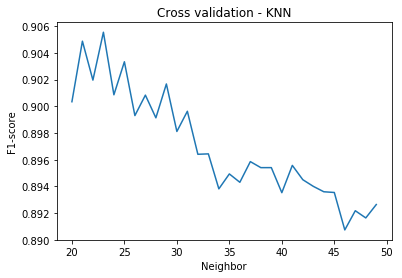

In [7]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
neighbors = np.arange(20,50,1).tolist()
cv_knn = [report_cv(KNeighborsClassifier(n_neighbors=neighbor),
               x_balanced,
               y_balanced).mean() 
            for neighbor in neighbors]
cv_knn = pd.Series(cv_knn, index = neighbors)
#plot do f1 na validação cruzada
cv_knn.plot(title = "Cross validation - KNN")
plt.xlabel("Neighbor")
plt.ylabel("F1-score")
print("A melhor quantidade de vizinhos é {0}, com F1 = {1}".format(cv_knn.idxmax(), cv_knn.max()))

#### Árvore de Decisão

A profundidade máxima ideal é 8, com F1 = 0.8817512675929422


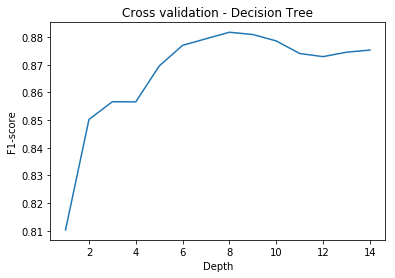

In [8]:
from sklearn.tree import DecisionTreeClassifier
depths = np.arange(1,15,1).tolist()
cv_tree = [report_cv(DecisionTreeClassifier(max_depth = depth),
                x_balanced,
                y_balanced).mean() 
            for depth in depths]
cv_tree = pd.Series(cv_tree, index = depths)
#plot do f1 na validação cruzada
cv_tree.plot(title = "Cross validation - Decision Tree")
plt.xlabel("Depth")
plt.ylabel("F1-score")
print("A profundidade máxima ideal é {0}, com F1 = {1}".format(cv_tree.idxmax(), cv_tree.max()))

#### Adaboost
Para o parâmetro max_depth utilizei a profundidade ideal encontrada para árvore de decisão.

A quantidade de árvores ideal é 37, com F1 = 0.9241687940766188


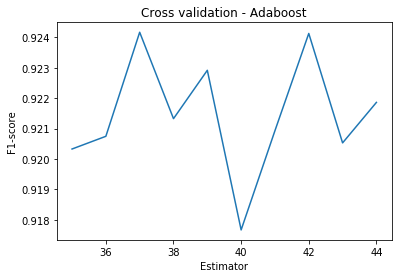

In [9]:
from sklearn.ensemble import AdaBoostClassifier
estimators = np.arange(35,45,1).tolist()
cv_ada =  [report_cv(AdaBoostClassifier(DecisionTreeClassifier(max_depth=cv_tree.idxmax()), 
                                    algorithm="SAMME", 
                                    n_estimators=estimator),
                x_balanced,
                y_balanced).mean() 
            for estimator in estimators]
cv_ada = pd.Series(cv_ada, index = estimators)
#plot do f1 na validação cruzada
cv_ada.plot(title = "Cross validation - Adaboost")
plt.xlabel("Estimator")
plt.ylabel("F1-score")
print("A quantidade de árvores ideal é {0}, com F1 = {1}".format(cv_ada.idxmax(), cv_ada.max()))


### 3) Reporte Precision, Recall e AUC-Precision&Recall no treino e validação. Há uma grande diferença de desempenho no treino/validação? Como você avalia os resultados? Justifique sua resposta.

In [10]:
def cv(model,x,y):
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    for train_index, validation_index in kf.split(x_balanced):
        model.fit(x[train_index,:], y[train_index])
        predicts = model.predict(x[validation_index,:])
        report = metrics.classification_report(y[validation_index], predicts, output_dict=True)
        return report

### 4) Interprete as saídas dos modelos. Quais atributos parecem ser mais importantes de acordo com cada modelo?

### 5) Envie seus melhores modelos à competição do Kaggle.

In [11]:
def test_model(model):
    model.fit(x_balanced, y_balanced)
    print(metrics.classification_report(y, model.predict(x), output_dict=True)["macro avg"]["f1-score"])

#### Regressão Logistíca

In [12]:
reg_log = LogisticRegression(solver="lbfgs", max_iter=10000, C=cv_logRegression.idxmax(), random_state=1)
test_model(reg_log)

0.7898396993630391


#### KNN

In [13]:
knn = KNeighborsClassifier(n_neighbors=cv_knn.idxmax())
test_model(knn)

0.6757542589035008


#### Decision Tree

In [14]:
tree = DecisionTreeClassifier(max_depth=cv_tree.idxmax())
test_model(tree)

0.8111408559169753


#### Adaboost

In [15]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=cv_tree.idxmax()), 
                                    algorithm="SAMME", 
                                    n_estimators=cv_ada.idxmax())
test_model(ada)

0.7644658871559173


### Testando Outros Modelos

#### Random Forest

Novamente, para o parâmetro max_depth utilizei a profundidade ideal encontrada para árvore de decisão

A quantidade de árvores ideal é 119, com F1 = 0.9112322893509119


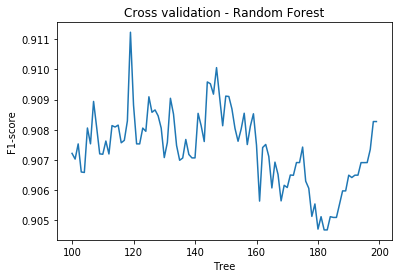

In [16]:
from sklearn.ensemble import RandomForestClassifier
trees = np.arange(100,200,1).tolist()
cv_random_forest = [report_cv(RandomForestClassifier(n_estimators=tree, max_depth=cv_tree.idxmax(), random_state=0),
                         x_balanced,
                         y_balanced).mean() 
                    for tree in trees]
cv_random_forest = pd.Series(cv_random_forest, index = trees)
#plot do AUC-Precision&Recall na validação cruzada
cv_random_forest.plot(title = "Cross validation - Random Forest")
plt.xlabel("Tree")
plt.ylabel("F1-score")
print("A quantidade de árvores ideal é {0}, com F1 = {1}".format(cv_random_forest.idxmax(), cv_random_forest.max()))

In [17]:
random_forest = RandomForestClassifier(n_estimators=cv_random_forest.idxmax(), max_depth=cv_tree.idxmax(), 
                                       random_state=10)
test_model(random_forest)

0.8312948550547654


#### Ridge

In [18]:
from sklearn.linear_model import RidgeClassifier
alphas = np.arange(90,110,0.1).tolist()
cv_ridge = [f1_cv(RidgeClassifier(alpha = alpha),
                          x_train, 
                          y_train).mean()
                    for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
#plot do AUC-Precision&Recall na validação cruzada
cv_ridge.plot(title = "Cross validation - Regression Ridge")
plt.xlabel("Alpha")
plt.ylabel("F1-score")
plt.show()
print("O melhor alpha é {0}, com F1 = {1}".format(cv_ridge.idxmax(), cv_ridge.max()))

NameError: name 'f1_cv' is not defined

In [ ]:
ridge = RidgeClassifier(alpha=cv_ridge.idxmax())
test_model(ridge)

### Regressão Logistíca L1

In [ ]:
from sklearn.linear_model import LogisticRegression
lambdas = np.arange(0.001,0.1,0.01).tolist()
cv_logRegression = [f1_cv(LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, C=lbd, random_state=1), 
                          x_train, y_train).mean()
                    for lbd in lambdas]
cv_logRegression = pd.Series(cv_logRegression, index = lambdas)

#plot do AUC-Precision&Recall na validação cruzada
cv_logRegression.plot(title = "Cross validation - Logistic Regression L1")
plt.xlabel("Lambda")
plt.ylabel("F1-score")
plt.show()
print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegression.idxmax(), cv_logRegression.max()))

In [ ]:
lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, 
                           C=cv_logRegression.idxmax(), random_state=1)
test_model(lasso)

### Submission

In [20]:
submission = pd.read_csv("../data/sample_submission.csv")
m = RandomForestClassifier(n_estimators=cv_random_forest.idxmax(), max_depth=cv_tree.idxmax(), 
                                       random_state=10)
m.fit(x_balanced, y_balanced)
predicts_submission = pd.DataFrame(m.predict(test))
predicts_submission = predicts_submission.replace([0, 1],['nao_eleito', 'eleito'])
submission["Predicted"] = predicts_submission
submission.to_csv("../data/sample_submission.csv")